In [1]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pmdarima as pm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [2]:
# Load the business demand data
BD = pd.read_csv("Business_demand_trends_20240901140306.csv")

# Remove the first 9 rows
BD = BD.iloc[9:].reset_index(drop=True)

# Convert 'Period start' to datetime format
BD['Period start'] = pd.to_datetime(BD['Period start'], format='%d/%m/%y')

# Let's assume you are interested in a specific "Region description", e.g., "Upper North Island"
region_description = "Upper North Island"  # Replace with desired "Region description"

# Filter for the specific "Region description"
BD_region = BD[BD['Region description'] == region_description]

# Split into training and validation sets by '2021-01-01'
split_date = '2021-01-01'
train_BD = BD_region[BD_region['Period start'] < split_date]
validation_BD = BD_region[BD_region['Period start'] >= split_date]

# Set 'Period start' as the index
train_BD.set_index('Period start', inplace=True)
validation_BD.set_index('Period start', inplace=True)

# Select 'Selected business demand (GWh)' as the target variable for analysis
y_train = train_BD['Selected business demand (GWh)']
y_validation = validation_BD['Selected business demand (GWh)']

# Apply 1st order regular differencing (to remove trend)
y_train_diff = y_train.diff().dropna()

# Apply seasonal differencing (assuming monthly data, so period=12)
y_train_diff_seasonal = y_train_diff.diff(12).dropna()

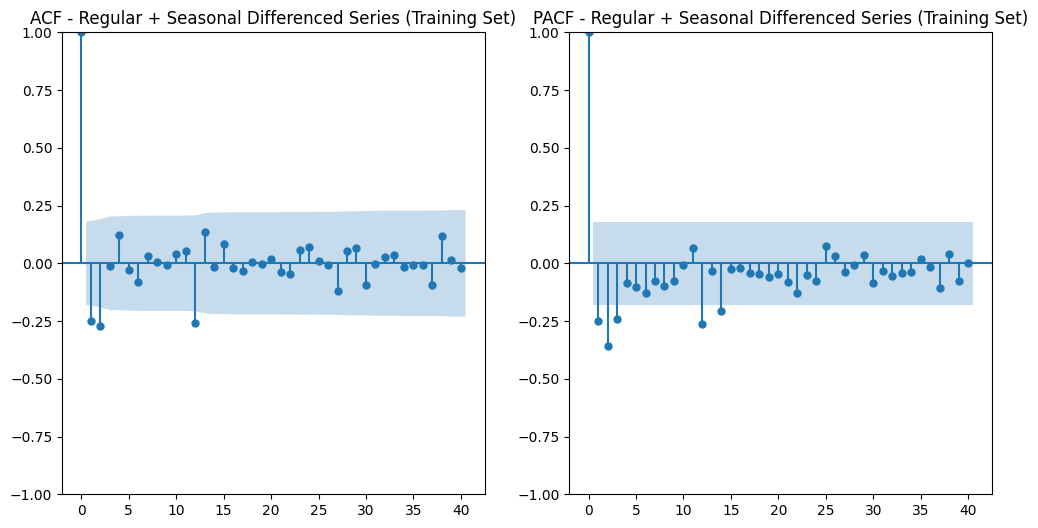

In [3]:
# Plot ACF and PACF for the series after regular and seasonal differencing
plt.figure(figsize=(12, 6))

plt.subplot(121)
plot_acf(y_train_diff_seasonal, lags=40, ax=plt.gca())
plt.title('ACF - Regular + Seasonal Differenced Series (Training Set)')

plt.subplot(122)
plot_pacf(y_train_diff_seasonal, lags=40, ax=plt.gca())
plt.title('PACF - Regular + Seasonal Differenced Series (Training Set)')

plt.show()

In [4]:
# Based on the ACF and PACF interpretation, we are building two SARIMA models: 
# 1. AR term focused model 
# 2. MA term focused model 

##########################
# Model 1: AR Term Focused
##########################
# SARIMA model with AR terms (4, 1, 0)x(1, 1, 0, 12)
sarima_model_1 = SARIMAX(y_train, order=(4, 1, 0), seasonal_order=(1, 1, 0, 12))
results_1 = sarima_model_1.fit()

# Forecast using Model 1
forecast_1 = results_1.forecast(steps=len(y_validation))

# Print the summary of Model 1
print(results_1.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.07869D+00    |proj g|=  6.46088D-02

At iterate    5    f=  4.04839D+00    |proj g|=  3.95556D-02

At iterate   10    f=  4.04231D+00    |proj g|=  2.11843D-02

At iterate   15    f=  4.03293D+00    |proj g|=  7.60088D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     18     22      1     0     0   8.060D-06   4.033D+00
  F =   4.0329057458842845     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
        

/Users/richardpeng/anaconda3/envs/Richard/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/richardpeng/anaconda3/envs/Richard/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


In [5]:
##########################
# Model 2: MA Term Focused
##########################
# SARIMA model with MA terms (0, 1, 3)x(0, 1, 1, 12)
sarima_model_2 = SARIMAX(y_train, order=(0, 1, 3), seasonal_order=(0, 1, 1, 12))
results_2 = sarima_model_2.fit()

# Forecast using Model 2
forecast_2 = results_2.forecast(steps=len(y_validation))

# Print the summary of Model 2
print(results_2.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.04354D+00    |proj g|=  3.37602D-02

At iterate    5    f=  4.03338D+00    |proj g|=  1.99163D-02

At iterate   10    f=  4.02121D+00    |proj g|=  1.75429D-02

At iterate   15    f=  4.02092D+00    |proj g|=  5.54463D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     15     20      1     0     0   5.545D-06   4.021D+00
  F =   4.0209230541589998     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
        

/Users/richardpeng/anaconda3/envs/Richard/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/richardpeng/anaconda3/envs/Richard/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


In [6]:
# SARIMA model with AR terms (4, 1, 0)x(0, 1, 1, 12)
sarima_model_3 = SARIMAX(y_train, order=(4, 1, 0), seasonal_order=(0, 1, 1, 12))
results_3 = sarima_model_3.fit()

# Forecast using Model 3
forecast_3 = results_3.forecast(steps=len(y_validation))

# Print the summary of Model 3
print(results_3.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.06619D+00    |proj g|=  5.92762D-02

At iterate    5    f=  4.06285D+00    |proj g|=  1.43141D-02

At iterate   10    f=  4.05564D+00    |proj g|=  2.67060D-02

At iterate   15    f=  4.05500D+00    |proj g|=  1.20270D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     17     21      1     0     0   1.426D-05   4.055D+00
  F =   4.0549964393669233     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
        

/Users/richardpeng/anaconda3/envs/Richard/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/richardpeng/anaconda3/envs/Richard/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


In [7]:
# SARIMA model with MA terms (0, 1, 3)x(1, 1, 0, 12)
sarima_model_4 = SARIMAX(y_train, order=(0, 1, 3), seasonal_order=(1, 1, 0, 12))
results_4 = sarima_model_4.fit()

# Forecast using Model 4
forecast_4 = results_4.forecast(steps=len(y_validation))

# Print the summary of Model 4
print(results_4.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.06099D+00    |proj g|=  4.72442D-02

At iterate    5    f=  4.02515D+00    |proj g|=  1.20215D-02

At iterate   10    f=  4.00731D+00    |proj g|=  4.75821D-02

At iterate   15    f=  4.00142D+00    |proj g|=  7.25149D-03

At iterate   20    f=  4.00135D+00    |proj g|=  2.09335D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     24      1     0     0   2.093D-06   4.001D+00
  F =   4.0013461022778474     

CONVERG

/Users/richardpeng/anaconda3/envs/Richard/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/richardpeng/anaconda3/envs/Richard/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


In [8]:
######################
# Auto ARIMA Model
######################
# Perform Auto ARIMA to automatically search for the best SARIMA model
auto_arima_model = pm.auto_arima(y_train, 
                                 seasonal=True, 
                                 m=12,  # Monthly seasonality
                                 d=1, D=1,  # Regular and seasonal differencing
                                 start_p=0, max_p=5,  # Start AR terms
                                 start_q=0, max_q=5,  # Start MA terms
                                 start_P=0, max_P=4,  # Start seasonal AR terms
                                 start_Q=0, max_Q=4,  # Start seasonal MA terms
                                 stepwise=False,  # Perform exhaustive search
                                 trace=False,  # Display search progress
                                 error_action='ignore', 
                                 suppress_warnings=True)

# Display the selected model summary
print(auto_arima_model.summary())

# Forecast using Auto ARIMA model
forecast_auto_arima = auto_arima_model.predict(n_periods=len(y_validation))

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  132
Model:             SARIMAX(0, 1, 2)x(1, 1, [], 12)   Log Likelihood                -528.214
Date:                             Thu, 03 Oct 2024   AIC                           1064.427
Time:                                     20:45:43   BIC                           1075.544
Sample:                                 01-01-2010   HQIC                          1068.941
                                      - 12-01-2020                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4858      0.072     -6.701      0.000      -0.628      -0.344
ma.L2         -0.4043      

In [9]:
######################
# Evaluation of Models
######################
# Function to calculate MAPE
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Calculate MAE, RMSE, MAPE for Model 1 (AR terms)
mae_1 = mean_absolute_error(y_validation, forecast_1)
rmse_1 = np.sqrt(mean_squared_error(y_validation, forecast_1))
mape_1 = mape(y_validation, forecast_1)

# Calculate MAE, RMSE, MAPE for Model 2 (MA terms)
mae_2 = mean_absolute_error(y_validation, forecast_2)
rmse_2 = np.sqrt(mean_squared_error(y_validation, forecast_2))
mape_2 = mape(y_validation, forecast_2)

mae_3 = mean_absolute_error(y_validation, forecast_3)
rmse_3 = np.sqrt(mean_squared_error(y_validation, forecast_3))
mape_3 = mape(y_validation, forecast_3)

mae_4 = mean_absolute_error(y_validation, forecast_4)
rmse_4 = np.sqrt(mean_squared_error(y_validation, forecast_4))
mape_4 = mape(y_validation, forecast_4)

# Calculate MAE, RMSE, MAPE for Auto ARIMA model
mae_auto = mean_absolute_error(y_validation, forecast_auto_arima)
rmse_auto = np.sqrt(mean_squared_error(y_validation, forecast_auto_arima))
mape_auto = mape(y_validation, forecast_auto_arima)

# Print the evaluation results
print(f"Model 1 (AR terms) - MAE: {mae_1}, RMSE: {rmse_1}, MAPE: {mape_1}")
print(f"Model 2 (MA terms) - MAE: {mae_2}, RMSE: {rmse_2}, MAPE: {mape_2}")
print(f"Model 3 (AR terms) - MAE: {mae_3}, RMSE: {rmse_3}, MAPE: {mape_3}")
print(f"Model 4 (MA terms) - MAE: {mae_4}, RMSE: {rmse_4}, MAPE: {mape_4}")
print(f"Auto ARIMA Model - MAE: {mae_auto}, RMSE: {rmse_auto}, MAPE: {mape_auto}")

Model 1 (AR terms) - MAE: 30.811409487245516, RMSE: 42.4223510131092, MAPE: 5.440865694202322
Model 2 (MA terms) - MAE: 26.90878895081909, RMSE: 38.709925468183904, MAPE: 4.7035037173486565
Model 3 (AR terms) - MAE: 28.07230400464878, RMSE: 37.09564085853443, MAPE: 4.960403550648745
Model 4 (MA terms) - MAE: 32.31086903238753, RMSE: 47.30758806464507, MAPE: 5.641584728870885
Auto ARIMA Model - MAE: 31.995635440410677, RMSE: 46.93051049733433, MAPE: 5.590189424521876
